In [142]:
import altair as alt
import pandas as pd

pos_1plus=[3573, 478, 116, 98, 611]
neg_1plus=[296, 32, 9, 8, 90]

pos_2plus=[3573, 478, 116, 80, 324]
neg_2plus=[75, 12, 1, 4, 29]

pos_5plus=[3573, 477, 114, 73, 156]
neg_5plus=[4, 2, 0, 0, 4]

pos_8plus=[3573, 476, 113, 68, 132]
neg_8plus=[1, 1, 0, 0, 3]

pos_10plus=[3573, 473, 110, 55, 124]
neg_10plus=[0, 0, 0, 0, 3]

# Sample data - replace with your actual data
data = pd.DataFrame({
    'category': ['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
    'positive_total': [3578, 480, 118, 124, 1310], # BLT50 total variants for actual sites with 1+ read
    'positive_validated': pos_1plus, # BLT50 validated variants for actual sites
    'negative_total': [3578, 480, 118, 124, 1310], # BLT50 total variants for +15bp sites with 1+ read (hopefully these numbers the same as ^)
    'negative_validated': neg_1plus # BLT50 validated variants for +15bp sites
})

# Create stacked data structure
data_stacked = []
for _, row in data.iterrows():
    category = row['category']
    
    # Calculate percentages for this category
    pos_validation_rate = (row['positive_validated'] / row['positive_total'] * 100) if row['positive_total'] > 0 else 0
    neg_validation_rate = (row['negative_validated'] / row['negative_total'] * 100) if row['negative_total'] > 0 else 0
    
    # Calculate unvalidated counts (difference between total and validated)
    pos_unvalidated = row['positive_total'] - row['positive_validated']
    neg_unvalidated = row['negative_total'] - row['negative_validated']
    
    # Positive side - unvalidated variants (bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_positive',
        'count': pos_unvalidated,
        'stack_order': 0,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Positive side - validated variants (stacked on top)
    data_stacked.append({
        'category': category,
        'direction': 'positive',
        'variant_type': 'validated',
        'variant_direction': 'validated_positive',
        'count': row['positive_validated'],
        'stack_order': 1,
        'validation_rate': pos_validation_rate,
        'total_count': row['positive_total'],
        'validated_count': row['positive_validated']
    })
    
    # Negative side - unvalidated variants (displayed as negative, bottom of stack)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'unvalidated',
        'variant_direction': 'unvalidated_negative',
        'count': -neg_unvalidated,
        'stack_order': 0,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })
    
    # Negative side - validated variants (stacked on negative side)
    data_stacked.append({
        'category': category,
        'direction': 'negative',
        'variant_type': 'validated',
        'variant_direction': 'validated_negative',
        'count': -row['negative_validated'],
        'stack_order': 1,
        'validation_rate': neg_validation_rate,
        'total_count': row['negative_total'],
        'validated_count': row['negative_validated']
    })

data_long = pd.DataFrame(data_stacked)

# Create the bidirectional stacked bar chart
chart = alt.Chart(data_long).mark_bar().encode(
    x=alt.X('category:O',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            title='Categories',
            axis=alt.Axis(labelAngle=60,labelFontSize=14, titleFontSize=16)),
        y=alt.Y('count:Q',
            title='Count',
            scale=alt.Scale(domain=[-3600, 3600]), # Adjust domain as needed
            stack='zero',
            axis=alt.Axis(labelFontSize=14, titleFontSize=16, labelExpr="abs(datum.value)")),
    color=alt.Color('variant_direction:N',
                    scale=alt.Scale(
                        domain=['validated_positive', 'unvalidated_positive', 'validated_negative', 'unvalidated_negative'],
                        range=['#018571', '#80cdc1', '#a6611a', '#dfc27d']
                        #=['#fd8d3c', '#756bb1', '#fdbe85', '#bcbddc']
                    ),
                    legend=alt.Legend(
                        title="Variant Type",
                        orient='right',
                        # legendX=150,
                        # legendY=700,
                        direction='vertical',
                        symbolType='square',
                        symbolSize=200,
                        titleFontSize=16,
                        labelFontSize=14,
                        labelExpr="datum.value == 'unvalidated_positive' ? 'Non-Validated' : datum.value == 'validated_positive' ? 'Validated' : datum.value == 'unvalidated_negative' ? 'Non-Validated Control' : 'Validated Control'"
                    )),
    order=alt.Order('stack_order:O'),
    tooltip=['category:O', 'direction:N', 'variant_type:N', 'count:Q', 'validation_rate:Q']
).properties(
    width=700,
    height=600,
    title=alt.TitleParams(
        text="BLT50 5%+ VAF Long Read Variant Validation Counts (1+ Reads)",
        fontSize=20,
        fontWeight='bold',
        dy=-10,
        dx=100,
        anchor='start'
    )
)

# Create data for percentage labels (one per category per direction)
label_data = []
for category in data['category'].unique():
    # Positive side label
    pos_row = data[data['category'] == category].iloc[0]
    pos_validation_rate = (pos_row['positive_validated'] / pos_row['positive_total'] * 100) if pos_row['positive_total'] > 0 else 0
    pos_y_position = pos_row['positive_total']  # Top of positive stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': pos_y_position + 50,  # Slightly above the bar
        'percentage': f"{pos_validation_rate:.1f}% ({pos_row['positive_validated']}/{pos_row['positive_total']})",
        'direction': 'positive'
    })
    
    # Negative side label
    neg_validation_rate = (pos_row['negative_validated'] / pos_row['negative_total'] * 100) if pos_row['negative_total'] > 0 else 0
    neg_y_position = -pos_row['negative_total']  # Bottom of negative stack (total height)
    
    label_data.append({
        'category': category,
        'y_position': neg_y_position - 50,  # Slightly below the bar
        'percentage': f"{neg_validation_rate:.1f}% ({pos_row['negative_validated']}/{pos_row['negative_total']})",
        'direction': 'negative'
    })

label_df = pd.DataFrame(label_data)

# Create percentage labels
percentage_labels = alt.Chart(label_df).mark_text(
    align='center',
    baseline='middle',
    fontSize=15,
    color='black',
    dy=alt.expr("datum.direction == 'positive' ? -3 : 3") 
).encode(
    x=alt.X('category:O'),
    y=alt.Y('y_position:Q'),
    text=alt.Text('percentage:N')
)

# Add a horizontal line at y=0 for reference
zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    color='black',
    strokeWidth=1
).encode(y='y:Q')

# Create section labels for positive and negative sides - positioned independently
section_label_data = pd.DataFrame([
    {'label': 'RUFUS-Called Sites', 'y_position': 3200, 'x_pos': 0},  # Top section
    {'label': 'Control Sites +15bp', 'y_position': -1800, 'x_pos': 0}  # Bottom section
])

# Create section labels for positive and negative sides
section_labels = alt.Chart(section_label_data).mark_text(
    align='right',
    baseline='middle',
    fontSize=12,
    fontWeight='bold',
    color='#333333',
    angle=270,  # Rotate text vertically like y-axis title
    dy=-50  # Position to the left of the chart area
).encode(
    x=alt.value(0),  # Fixed x position
    y=alt.Y('y_position:Q', scale=alt.Scale(domain=[-3600, 3600])),
    text=alt.Text('label:N')
)

# Combine all charts
final_chart = alt.layer(
    chart,
    zero_line,
    percentage_labels,
    section_labels
).resolve_scale(
    color='independent'
)

# Display the chart
final_chart.show()

# Optional: Save the chart
# final_chart.save('bidirectional_bar_chart.html')
# final_chart.save('bidirectional_bar_chart.png', scale_factor=2.0)

alt.LayerChart(...)

In [154]:
import altair as alt
import pandas as pd

# Your data arrays
pos_1plus = [3573, 478, 116, 98, 611]
neg_1plus = [296, 32, 9, 8, 90]

pos_2plus = [3573, 478, 116, 80, 324]
neg_2plus = [75, 12, 1, 4, 29]

pos_5plus = [3573, 477, 114, 73, 156]
neg_5plus = [4, 2, 0, 0, 4]

pos_8plus = [3573, 476, 113, 68, 132]
neg_8plus = [1, 1, 0, 0, 3]

pos_10plus = [3573, 473, 110, 55, 124]
neg_10plus = [0, 0, 0, 0, 3]

# Total counts (same for all thresholds)
pos_totals = [3578, 480, 118, 124, 1310]
neg_totals = [3578, 480, 118, 124, 1310]

categories = ['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)']

# Create comprehensive dataset for line chart
trend_data = []
datasets = {
    '1+ Reads': (pos_1plus, neg_1plus),
    '2+ Reads': (pos_2plus, neg_2plus),
    '5+ Reads': (pos_5plus, neg_5plus),
    '8+ Reads': (pos_8plus, neg_8plus),
    '10+ Reads': (pos_10plus, neg_10plus)
}

for threshold, (pos_validated, neg_validated) in datasets.items():
    for i, category in enumerate(categories):
        # Positive validation percentage
        pos_rate = (pos_validated[i] / pos_totals[i] * 100) if pos_totals[i] > 0 else 0
        trend_data.append({
            'category': category,
            'threshold': threshold,
            'validation_rate': pos_rate,
            'site_type': 'RUFUS-Called',
            'line_id': f'{threshold} RUFUS-Called',
            'validated_count': pos_validated[i],
            'total_count': pos_totals[i]
        })
        
        # Negative validation percentage
        neg_rate = (neg_validated[i] / neg_totals[i] * 100) if neg_totals[i] > 0 else 0
        trend_data.append({
            'category': category,
            'threshold': threshold,
            'validation_rate': neg_rate,
            'site_type': 'Control',
            'line_id': f'{threshold} Control',
            'validated_count': neg_validated[i],
            'total_count': neg_totals[i]
        })

trend_df = pd.DataFrame(trend_data)

# Create the single line chart with all 10 lines
line_chart = alt.Chart(trend_df).mark_line(
    strokeWidth=3,
    point=alt.OverlayMarkDef(size=80, filled=True)
).encode(
    x=alt.X('category:O', 
            title='Category',
            sort=['Σ C(5,5)', 'Σ C(5,4)', 'Σ C(5,3)', 'Σ C(5,2)', 'Σ C(5,1)'],
            axis=alt.Axis(labelAngle=45, labelFontSize=14, titleFontSize=16)),
    y=alt.Y('validation_rate:Q',
            title='Validation Percentage (%)',
            scale=alt.Scale(domain=[0, 100]),
            axis=alt.Axis(labelFontSize=14, titleFontSize=16)),
    color=alt.Color('threshold:N',
                    scale=alt.Scale(
                        domain=['1+ Reads', '2+ Reads', '5+ Reads', '8+ Reads', '10+ Reads'],
                        range=['#e41a1c', '#ff7f00', '#4daf4a', '#377eb8', '#984ea3']  # One color per threshold
                    ),
                    legend=alt.Legend(
                        title="Read Threshold",
                        titleFontSize=14,
                        labelFontSize=12,
                        orient='top-left'
                    )),
    strokeDash=alt.StrokeDash('site_type:N',
                            scale=alt.Scale(
                                domain=['RUFUS-Called', 'Control'],
                                range=[[0], [5,5]]  # Solid for RUFUS-Called, dashed for Control
                            ),
                            legend=alt.Legend(
                                title="Site Type",
                                titleFontSize=14,
                                labelFontSize=16,
                                orient='top-right',
                                symbolType='stroke',
                                symbolStrokeWidth=3,
                                values=['RUFUS-Called', 'Neg Control']
                            )),
    tooltip=['threshold:O', 'category:O', 'site_type:N', 'validation_rate:Q', 'validated_count:Q', 'total_count:Q']
).properties(
    width=800,
    height=500,
    title=alt.TitleParams(
        text="Validation Rate Trends: RUFUS-Called vs Control Sites Across Read Thresholds",
        fontSize=20,
        anchor="middle",
        fontWeight='bold',
    )
)

# Display the chart
line_chart.show()

# Optional: Save the chart
# line_chart.save('validation_trends.html')
# line_chart.save('validation_trends.png', scale_factor=2.0)

alt.Chart(...)

In [1]:
# Long read coverage plots
# Data taken from DAC website sample metadata 14Aug2025

pacbio=[35, 43, 28, 27, 22, 102, 37, 36, 33, 24]
ont=[26, 87, 38, 36, 30]

pacbio_sum=0
for i in range(len(pacbio)):
    pacbio_sum+=pacbio[i]
avg_pacbio=pacbio_sum/len(pacbio)
print(f"PacBio Average Coverage: {avg_pacbio:.1f}x")
ont_sum=0
for i in range(len(ont)):
    ont_sum+=ont[i]
avg_ont=ont_sum/len(ont)
print(f"ONT Average Coverage: {avg_ont:.1f}x")

total_sum=pacbio_sum+ont_sum
total_count=len(pacbio)+len(ont)
avg_total=total_sum/total_count
print(f"Overall Average Coverage: {avg_total:.1f}x")



PacBio Average Coverage: 38.7x
ONT Average Coverage: 43.4x
Overall Average Coverage: 40.3x


✓ Input data validation passed
Detected samples: ['BCM', 'Broad', 'NYGC', 'UW', 'WashU', 'Truth Set']


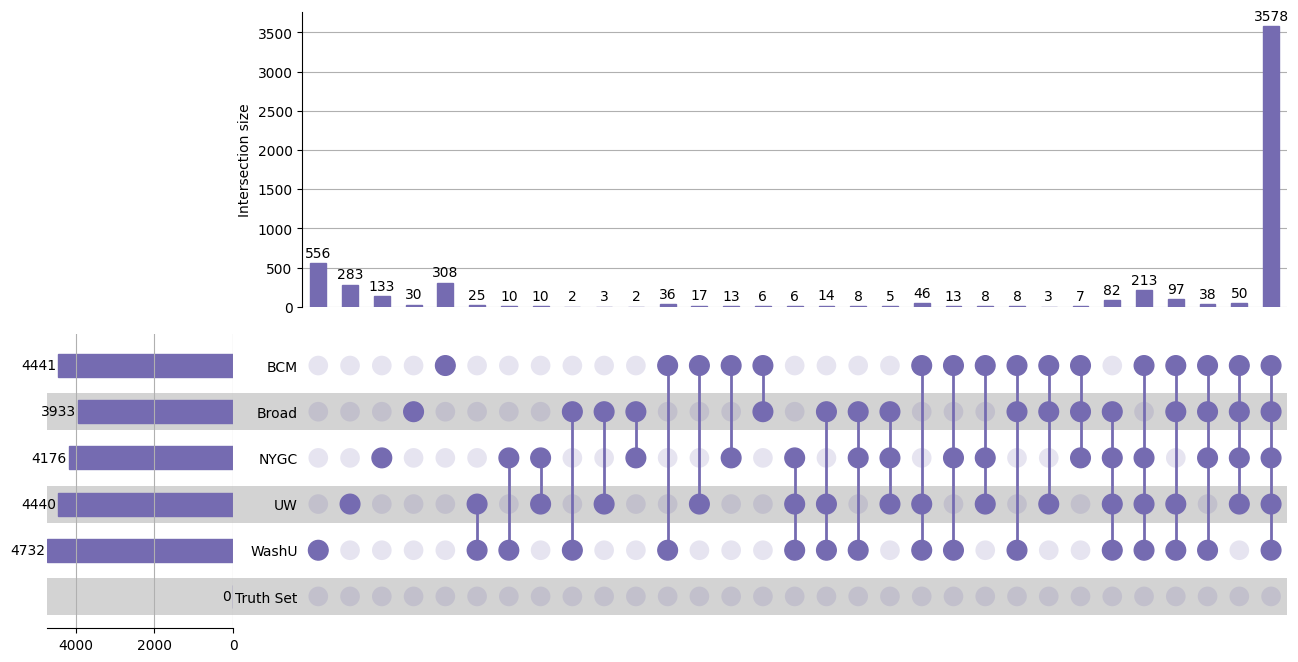

In [55]:
# Upset plots

import pandas as pd
import numpy as np
from upsetplot import UpSet
import matplotlib.pyplot as plt
import warnings

# Suppress pandas future warnings related to inplace operations
warnings.filterwarnings('ignore', category=FutureWarning)

def create_upset_from_intersection_counts(intersection_data, sample_names=None):
    """
    Create an UpSet plot from intersection count data.
    
    Parameters:
    -----------
    intersection_data : dict
        Dictionary where keys are intersection strings (e.g., 'A&B&C') 
        and values are counts
    sample_names : list, optional
        List of sample names. If None, will be inferred from the data.
    
    Returns:
    --------
    pandas.Series with MultiIndex for upsetplot
    """
    
    # If sample_names not provided, infer from the data
    if sample_names is None:
        all_samples = set()
        for intersection_str in intersection_data.keys():
            samples_in_intersection = intersection_str.split('&')
            all_samples.update(samples_in_intersection)
        sample_names = sorted(list(all_samples))
    
    print(f"Detected samples: {sample_names}")
    
    # Create multi-index data more explicitly to avoid pandas warnings
    index_tuples = []
    counts = []
    
    for intersection_str, count in intersection_data.items():
        # Parse which samples are in this intersection
        samples_in_intersection = set(intersection_str.split('&'))
        
        # Create boolean tuple for this intersection
        membership = tuple(sample in samples_in_intersection for sample in sample_names)
        
        index_tuples.append(membership)
        counts.append(count)
    
    # Create MultiIndex explicitly
    multi_index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=sample_names
    )
    
    # Create Series with the counts - ensure it's properly formatted
    series = pd.Series(data=counts, index=multi_index, dtype=int)
    
    # Remove any zero counts to clean up the plot
    series = series[series > 0]
    
    # Sort by values (descending) to show largest intersections first
    series = series.sort_values(ascending=False)
    
    return series, sample_names

def plot_upset(series, sample_names, title="UpSet Plot", figsize=(16, 8), sample_colors=None, **kwargs):
    """
    Create and display the UpSet plot.
    
    Parameters:
    -----------
    series : pd.Series
        Series with MultiIndex containing the intersection counts
    sample_names : list
        List of sample names
    title : str
        Plot title
    figsize : tuple
        Figure size
    sample_colors : dict or list, optional
        Colors for each sample. Can be:
        - dict: {'A': 'red', 'B': 'blue', ...}
        - list: ['red', 'blue', 'green', ...] (in order of sample_names)
        - None: uses default colors
    **kwargs : additional arguments for UpSet
    """
    
    # Suppress the tight_layout warning
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='This figure includes Axes that are not compatible with tight_layout')
        
        # Default UpSet parameters (can be overridden by kwargs)
        upset_params = {
            'show_counts': True,
            'sort_by': 'degree',
            #'facecolor': '#d94701',
            'facecolor': '#756bb1',
            'shading_color': 'lightgray',
            'sort_categories_by': 'cardinality',
            'min_subset_size': 1,  # Show all intersections with at least 1 variant
            'element_size': None,  # Don't normalize - show actual counts
            'totals_plot_elements': 6  # Limit number of total elements shown
        }
        upset_params.update(kwargs)
        
        try:
            upset = UpSet(series, **upset_params)
            fig = upset.plot(fig=plt.figure(figsize=figsize))
        
            
            # Now customize the dot colors in the matrix plot
            # Find the intersection matrix axes
            axes = fig.get_axes()
            matrix_ax = None
            
            # The matrix plot is typically one of the lower axes
            for ax in axes:
                # Look for the axis that has scatter plots (dots)
                if hasattr(ax, 'collections') and len(ax.collections) > 0:
                    # Check if this looks like the matrix plot
                    if any(hasattr(coll, 'get_offsets') and len(coll.get_offsets()) > 0 
                           for coll in ax.collections):
                        matrix_ax = ax
                        break
            
            if matrix_ax is not None:
                # Clear existing dots and redraw with custom colors
                matrix_ax.clear()
                
                # Get the intersection data to redraw the matrix
                intersections = []
                for idx, count in series.items():
                    intersections.append(idx)
                
                # Redraw the matrix with colored dots
                for col_idx, intersection in enumerate(intersections):
                    for row_idx, (sample_name, is_present) in enumerate(zip(sample_names, intersection)):
                        if is_present:
                            # Draw filled dot with sample-specific color
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c=sample_colors[sample_name], 
                                            s=100, 
                                            edgecolors='black', 
                                            linewidths=0.5,
                                            zorder=3)
                        else:
                            # Draw gray dot for non-membership
                            matrix_ax.scatter(col_idx, row_idx, 
                                            c='lightgray', 
                                            s=30, 
                                            alpha=0.3,
                                            zorder=1)
                
                # Draw connecting lines for multi-sample intersections
                for col_idx, intersection in enumerate(intersections):
                    present_rows = [i for i, is_present in enumerate(intersection) if is_present]
                    if len(present_rows) > 1:
                        # Draw vertical line connecting present samples
                        min_row = min(present_rows)
                        max_row = max(present_rows)
                        matrix_ax.plot([col_idx, col_idx], [min_row, max_row], 
                                     'black', linewidth=2, alpha=0.6, zorder=2)
                
                # Set up the matrix axes
                matrix_ax.set_xlim(-0.5, len(intersections) - 0.5)
                matrix_ax.set_ylim(-0.5, len(sample_names) - 0.5)
                matrix_ax.set_xticks([])
                matrix_ax.set_yticks(range(len(sample_names)))
                matrix_ax.set_yticklabels(sample_names)
                matrix_ax.invert_yaxis()
                matrix_ax.grid(True, alpha=0.3)
                
                # Remove x-axis labels as they're not needed in the matrix
                matrix_ax.set_xlabel('')
            
            # Add title with manual positioning to avoid layout issues
            plt.suptitle(title, fontsize=14, y=0.98)
            
            # Use subplots_adjust instead of tight_layout for better control
            plt.subplots_adjust(top=0.92, bottom=0.1, left=0.1, right=0.95, hspace=0.3, wspace=0.3)
            
            # Add a color legend for samples only
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=color, edgecolor='black', label=name) 
                             for name, color in sample_colors.items()]
            plt.figlegend(handles=legend_elements, 
                         loc='upper left', 
                         bbox_to_anchor=(0.02, 0.98),
                         title='Samples')
            
            plt.show()
            
            return upset
            
        except Exception as e:
        #     print(f"Error creating UpSet plot: {e}")
        #     print("Falling back to summary statistics...")
            
        #     # Print data summary if plot fails
        #     print(f"\nData Summary:")
        #     print(f"Series shape: {series.shape}")
        #     print(f"Series index names: {series.index.names}")
        #     print(f"Top 10 intersections:")
        #     print(series.sort_values(ascending=False).head(10))
            
             return None

def validate_intersection_data(intersection_data):
    """
    Validate the input data format and provide helpful error messages.
    """
    if not isinstance(intersection_data, dict):
        raise ValueError("intersection_data must be a dictionary")
    
    if len(intersection_data) == 0:
        raise ValueError("intersection_data cannot be empty")
    
    # Check for valid format
    for key, value in intersection_data.items():
        if not isinstance(key, str):
            raise ValueError(f"All keys must be strings, found: {type(key)}")
        
        if not isinstance(value, (int, float)):
            raise ValueError(f"All values must be numeric, found: {type(value)} for key '{key}'")
        
        if value < 0:
            raise ValueError(f"All values must be non-negative, found: {value} for key '{key}'")
        
        # Check that intersection string uses '&' separator
        if '&' not in key and len(key.split('&')) == 1:
            # Single sample - this is OK
            pass
        elif '&' in key:
            # Multiple samples - check format
            samples = key.split('&')
            if any(len(sample.strip()) == 0 for sample in samples):
                raise ValueError(f"Invalid intersection format: '{key}'. Check for empty sample names.")
    
    print("✓ Input data validation passed")
    return True

def main_example():
    all_isecs = {
        'BCM': 308,
        'Broad': 30,
        'NYGC': 133,
        'UW': 283,
        'WashU': 556, 
        'BCM&Broad': 6,
        'BCM&NYGC': 13,
        'BCM&UW': 17,
        'BCM&WashU': 36,
        'Broad&NYGC': 2,
        'Broad&UW': 3,
        'Broad&WashU': 2,
        'NYGC&UW': 10,
        'NYGC&WashU': 10,
        'UW&WashU': 25,
        'BCM&Broad&NYGC': 7,
        'BCM&Broad&UW': 3,
        'BCM&Broad&WashU': 8,
        'BCM&NYGC&UW': 8,
        'BCM&NYGC&WashU': 13,
        'BCM&UW&WashU': 46,
        'Broad&NYGC&UW': 5,
        'Broad&NYGC&WashU': 8,
        'Broad&UW&WashU': 14,
        'NYGC&UW&WashU': 6,
        'BCM&Broad&NYGC&UW': 50,
        'BCM&Broad&NYGC&WashU': 38,
        'BCM&Broad&UW&WashU': 97,
        'BCM&NYGC&UW&WashU': 213,
        'Broad&NYGC&UW&WashU': 82,
        'BCM&Broad&NYGC&UW&WashU': 3578
    }
    
    # Validate input data
    validate_intersection_data(all_isecs)
    
    # Specify sample names explicitly (optional - will be inferred if not provided)
    sample_names = ['BCM', 'Broad', 'NYGC', 'UW', 'WashU', 'Truth Set']
    
    # Create the UpSet plot
    series, detected_samples = create_upset_from_intersection_counts(
        all_isecs, sample_names
    )
    
    # print(f"\nCreated series with {len(series)} intersections")
    # print(f"Sample order: {detected_samples}")
    
    upset = plot_upset(
        series, 
        detected_samples,
        title="5%+ AF Variant Intersections Called In GCC Combinations Not In Truth Set",
        min_subset_size=1,     # Show all intersections with at least 1 variant
        show_counts=True,      # Show count numbers on bars
        sort_by='degree', # Sort by intersection size
        sort_categories_by='-input'  # Sort sample categories by size
    )
    
    # Print summary
    # if series is not None:
    #     print(f"\nSummary:")
    #     print(f"Total intersections: {len(series)}")
    #     print(f"Total variants across all intersections: {series.sum()}")
    #     print(f"Largest intersection: {series.max()} variants")
    #     print(f"Smallest intersection: {series.min()} variants")
    #     print(f"Mean intersection size: {series.mean():.1f} variants")
        
    #     # Show top intersections
    #     print(f"\nTop 10 intersections by size:")
    #     top_intersections = series.sort_values(ascending=False).head(10)
    #     for idx, value in top_intersections.items():
    #         # Convert boolean tuple back to sample names
    #         samples_in_intersection = [sample_names[i] for i, is_member in enumerate(idx) if is_member]
    #         intersection_str = '&'.join(samples_in_intersection)
    #         print(f"  {intersection_str}: {value} variants")
    
    return series, upset

if __name__ == "__main__":
    # Run the example
    series, upset = main_example()